In [1]:
import viz
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_id(model, dataset):
    df = pd.read_csv('./experiments/results.txt', names=range(8))
    df[1] = df[1].str.strip()
    df[3] = df[3].astype(str).astype(float)
    id_model = df[(df[0]==model)&(df[1]==dataset)&(df[7]==1)][df[3]==df[3].max()][2]
    print(id_model)
    return model, dataset, id_model

In [3]:
DATASET = 'iris'
MODEL = 'ann'
OOD = True

In [4]:
ann_url = viz.get_model_url('ann', DATASET, '1616778484')
ann_args = viz.load_args(ann_url)
x_train, x_val, x_test, y_train, y_val, y_test, ood_x, ood_y = viz.load_data(ann_args)
ann_model = viz.load_model(ann_url, x_train.shape[1], y_train.shape[1], ann_args)

iris


In [5]:
jehm_url = viz.get_model_url('jehm', DATASET, '1616778442')
jehm_args = viz.load_args(jehm_url)
jehm_model = viz.load_model(jehm_url, x_train.shape[1], y_train.shape[1], jehm_args)

Samples: 20


In [6]:
jem_url = viz.get_model_url('jem', DATASET, '1616778501')
jem_args = viz.load_args(jem_url)
jem_model = viz.load_model(jem_url, x_train.shape[1], y_train.shape[1], jem_args)

In [7]:
# Best one thus far 1617305583
jehmo_url = viz.get_model_url('jehmo', DATASET, '1617305583')
jehmo_args = viz.load_args(jehmo_url)
jehmo_model = viz.load_model(jehmo_url, x_train.shape[1], y_train.shape[1], jehmo_args)

Samples: 20


In [8]:
jehmo_model.n_epochs

0

In [9]:
jemo_url = viz.get_model_url('jemo', DATASET, '1615528859')
jemo_args = viz.load_args(jemo_url)
jemo_model = viz.load_model(jemo_url, x_train.shape[1], y_train.shape[1], jemo_args)

ValueError: Tensor's shape (128, 3) is not compatible with supplied shape (128, 2)

In [10]:
plt.rcParams["figure.figsize"] = (20,3)
def leave_cvx_hull(model_list, x, y):
    fig, axs = plt.subplots(1, 3)
    fig.suptitle('Leaving cvx hull')
    for i, y_lbl in enumerate(['accuracy', 'confidence', 'entropy']):
        for model in model_list:
            y_list = []
            for u in range(0, 1000, 100):
                y_plot=0
                t = np.random.uniform(-1, 1, size=x.shape)
                py_x = tf.nn.softmax(model(x + u*t))
                if y_lbl=='entropy':
                    y_plot = -tf.reduce_mean(tf.reduce_sum(py_x*tf.math.log(py_x), axis=1))
                if y_lbl=='accuracy':
                    y_plot = tf.reduce_mean(tf.cast(
                        tf.argmax(py_x, axis=1)==tf.argmax(y, axis=1), tf.float32))
                if y_lbl=='confidence':
                    y_plot = tf.reduce_mean(tf.reduce_max(py_x, 1))
                y_list.append(y_plot.numpy())
            axs[i].plot(np.array(y_list), label=model.name)
        axs[i].set(xlabel='perturbation', ylabel=y_lbl+' (mean)')
        axs[i].legend()

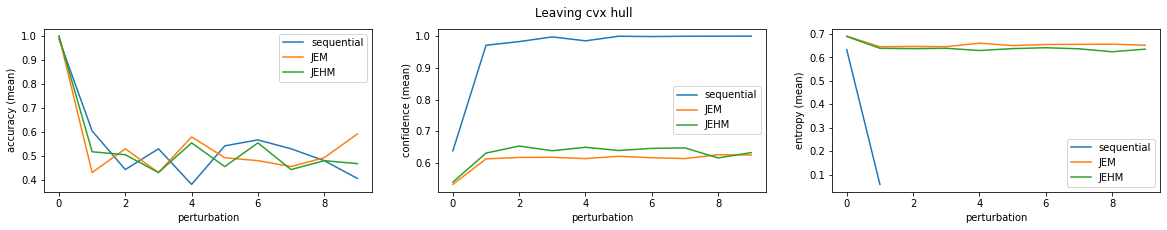

In [29]:
leave_cvx_hull([ann_model, jem_model, jehm_model], x_train, y_train)

In [12]:
def confidence_plot(models, x, xo):
    for model in models:
        p_in = tf.reduce_max(tf.nn.softmax(model(x)), axis=1)
        p_out = tf.reduce_max(tf.nn.softmax(model(xo)), axis=1)
        plt.ylabel('Frequency')
        plt.xlabel('Confidence')
        plt.xlim([0, 1])
        plt.hist(p_in.numpy(), bins=20, label=f'In {model.name}', alpha=.5)
        plt.hist(p_out.numpy(), bins=20, label=f'Out {model.name}', alpha=.5)
        plt.legend()

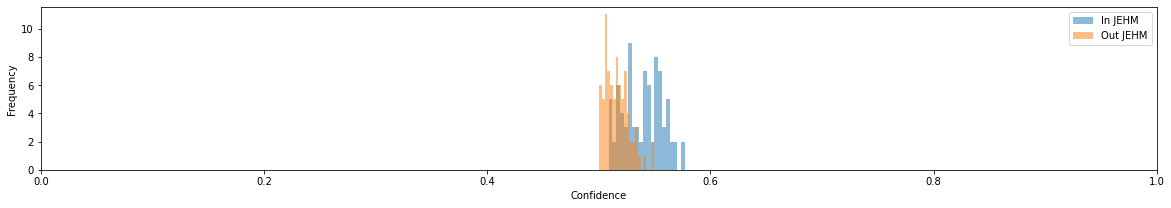

In [27]:
xgo = jehmo_model.sample_ood(x_train)
confidence_plot([jehm_model], x_train, xgo)

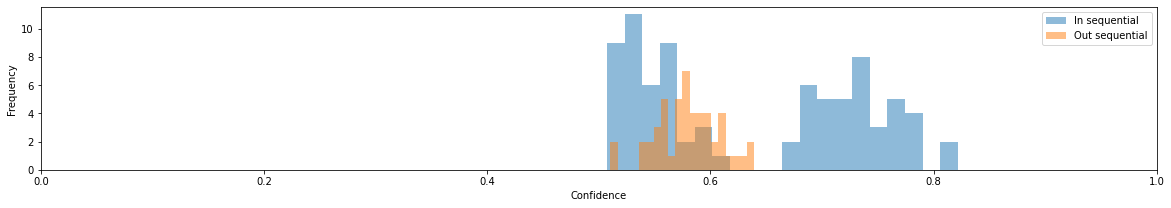

In [14]:
confidence_plot([ann_model], x_train, ood_x)

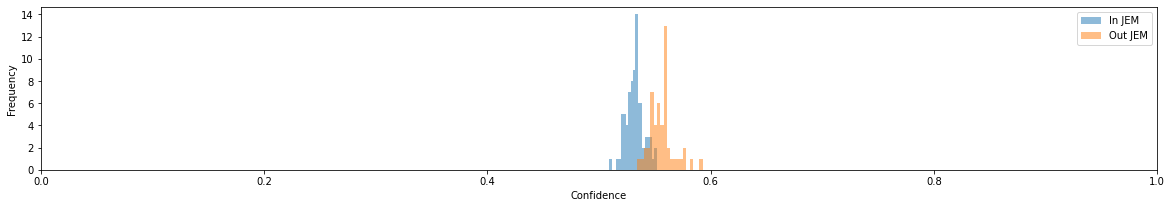

In [15]:
confidence_plot([jem_model], x_train, ood_x)

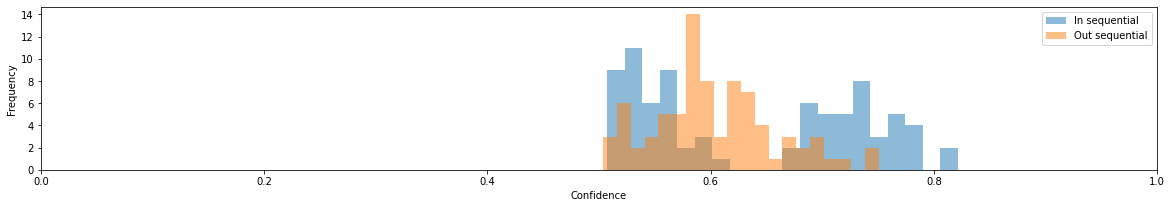

In [25]:
confidence_plot([ann_model], x_train, xgo)

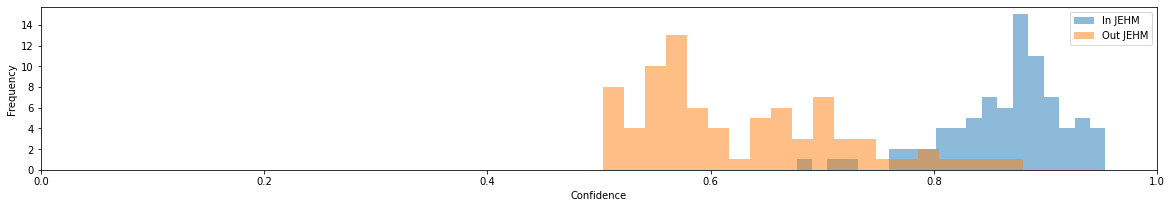

In [26]:
confidence_plot([jehmo_model], x_train, xgo)

In [18]:
def analyze_features(model, x, xo, idx):
    plt.figure()
    plt.hist(x[:, idx], bins=20, color='blue', label='sample', alpha=.5)
    plt.hist(xo[:, idx], bins=20, color='red', label='ood', alpha=.5)
    if model.name in ['JEM', 'JEHM']:
        xgo = model.sample_ood(x)
        plt.hist(xgo[:, idx].numpy(), bins=20, color='green', label='gen_o', alpha=.5)
    plt.legend()
    plt.show()

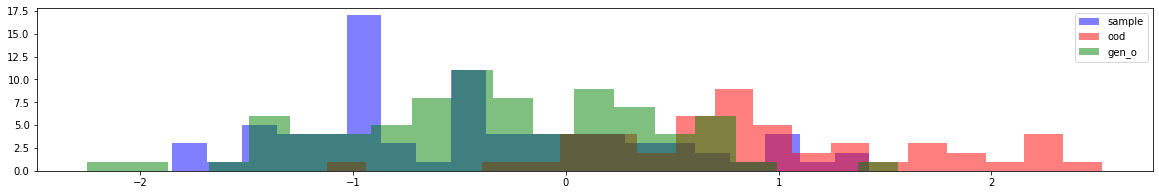

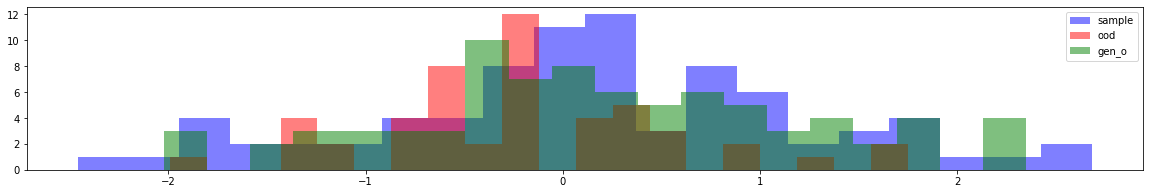

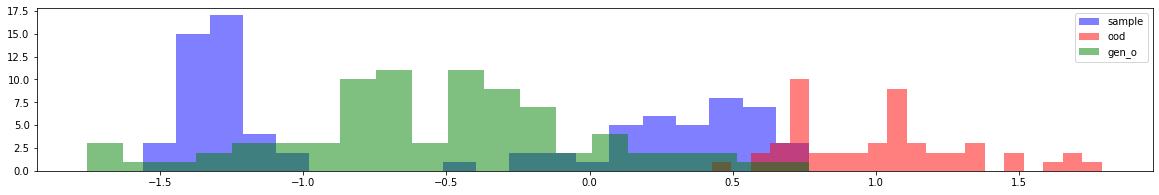

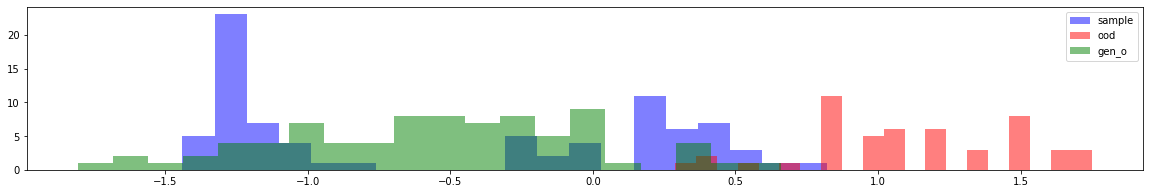

In [19]:
for i in range(4):
    analyze_features(jehmo_model, x_train, ood_x, i)

In [20]:
def calibration_plot(model, x, y, ece):
    py_x = tf.nn.softmax(model(x))
    p = tf.reduce_max(py_x, axis=1).numpy()
    
    hat_y = tf.argmax(py_x, axis=1)
    y = tf.argmax(y, axis=1)
    acc = tf.cast(hat_y==y, tf.float32).numpy()
    
    acc_list = []
    p_list = []
    for i in np.arange(0,1,.1):
        idx_u = p<=i+.1
        idx_l = i<=p
        idx = idx_l*idx_u
        if p[idx]!=[]:
            p_list.append(np.mean(p[idx]))
            acc_list.append(np.mean(acc[idx]))
        else:
            p_list.append(0)
            acc_list.append(0)
    print(p_list)
    print(acc_list)
    plt.title(f'Calibration {model.name}: {ece}')
    plt.ylabel('Frequency')
    plt.xlabel('ACC/Conf')
    plt.xlim([0, 1])
    plt.bar(np.arange(0,1,.1), height=acc_list, width=.1,
            color='blue', label='accuracy', alpha=.75)
    plt.bar(np.arange(0,1,.1), height=p_list, width=.1,
            color='red', label='confidence', alpha=.75)
    plt.legend()

/Users/JJ/venv/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
/Users/JJ/venv/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


[0, 0, 0, 0, 0, 0.5374074, 0.6943319, 0.7179047, 0, 0]
[0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 0, 0]


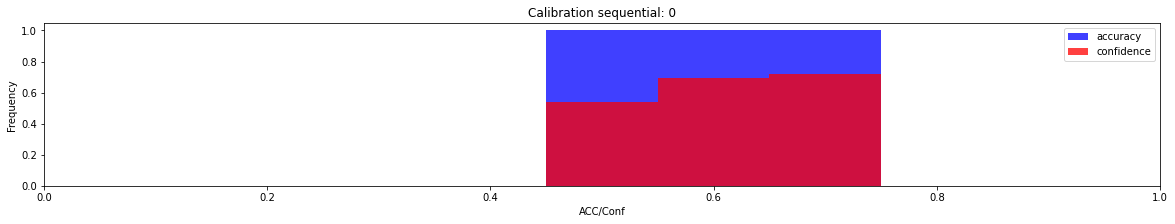

In [21]:
calibration_plot(ann_model, x_test, y_test, 0)

/Users/JJ/venv/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
/Users/JJ/venv/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


[0, 0, 0, 0, 0, 0, 0, 0, 0.8451802, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0]


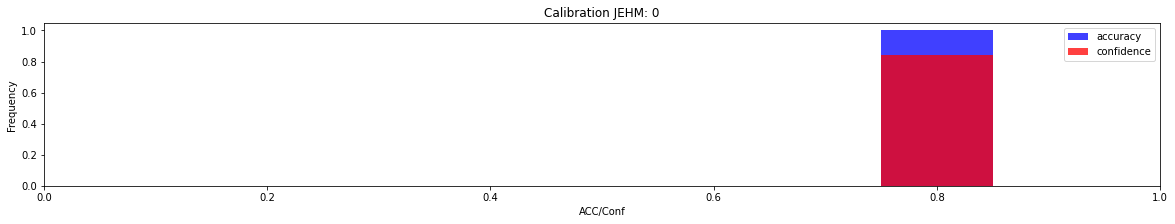

In [22]:
calibration_plot(jehmo_model, x_test, y_test, 0)

/Users/JJ/venv/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
/Users/JJ/venv/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


[0, 0, 0, 0, 0, 0.52926433, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0]


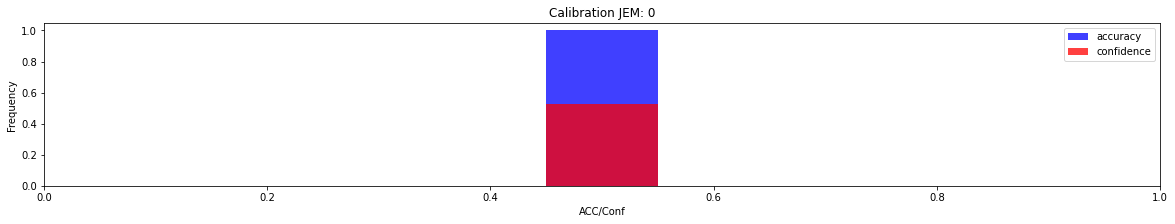

In [23]:
calibration_plot(jem_model, x_test, y_test, 0)